In [1]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# Read data
df = pd.read_csv('df_for_model_building.csv')

# Keep only the price column and variables that correspond to distance to neighbourhood amenities 
df = df.ix[:,['price', 'restaurant', 'atm', 'cinema', 'hospital', 'nightclub', 'park','mall', 
              'gallery', 'museum', 'supermarket', 'bus_stop']]
df.head()

,price,restaurant,atm,cinema,hospital,nightclub,park,mall,gallery,museum,supermarket,bus_stop
0,39,585.0,509,5812,5400.0,1060.0,3269,7227.0,15000.0,9607.0,1709,72.0
1,45,285.0,1212,5480,4588.0,1151.0,2694,6488.0,15000.0,9476.0,1213,77.0
2,31,858.0,1267,5561,5063.0,1622.0,3368,7074.0,15000.0,15000.0,1200,85.0
3,39,757.0,704,5858,5254.0,1128.0,3213,7121.0,15000.0,9675.0,1681,25.0
4,39,529.0,514,5661,5287.0,912.0,3115,7089.0,15000.0,9463.0,1862,145.0


In [3]:
# Normalizing each column by min-max normalization before clustering
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 

for col in df.columns:
    df[col] = scaler.fit_transform(df[col].values.reshape((df.shape[0],1)))

df.head()

/home/hareesh/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


,price,restaurant,atm,cinema,hospital,nightclub,park,mall,gallery,museum,supermarket,bus_stop
0,0.101961,0.195000,0.104879,0.461330,0.238985,0.070481,0.666324,0.481385,1.0,0.640371,0.577770,0.046729
1,0.125490,0.095000,0.251460,0.434914,0.202848,0.076549,0.547962,0.432079,1.0,0.631635,0.409692,0.050067
2,0.070588,0.286000,0.262927,0.441359,0.223988,0.107955,0.686702,0.471177,1.0,1.000000,0.405286,0.055407
3,0.101961,0.252333,0.145538,0.464990,0.232488,0.075015,0.654796,0.474313,1.0,0.644905,0.568282,0.015354
4,0.101961,0.176333,0.105922,0.449316,0.233956,0.060612,0.634623,0.472178,1.0,0.630768,0.629617,0.095461


In [4]:
from sklearn.cluster import KMeans
inertia_dict = {}
for n in range(1,11):
    cluster_model = KMeans(n_clusters=n, init='k-means++', random_state=13)
    cluster_model.fit(df)
    inertia_dict[n] = cluster_model.inertia_

In [5]:
inertia_dict # Steepest slope is from 1 to 2. So 2 is the optimal number of clusters

{1: 3674.6250903914543,
 2: 2078.7167437297094,
 3: 1733.4498839613684,
 4: 1519.9381643339473,
 5: 1343.3754904568329,
 6: 1230.4384869370087,
 7: 1136.848413082595,
 8: 1060.136929887839,
 9: 1009.6786807705128,
 10: 966.20818079913488}

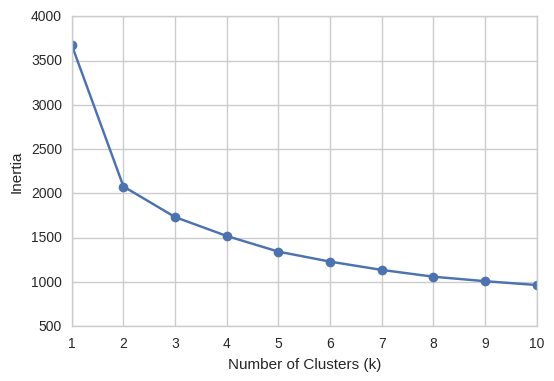

In [9]:
ax = pd.Series(inertia_dict.values(), index=inertia_dict.keys()).plot(marker='o')
ax.set(xlabel='Number of Clusters (k)', ylabel='Inertia')

In [10]:
cluster_model = KMeans(n_clusters=2, init='k-means++', random_state=13)
cluster_model.fit(df)
cluster_model.inertia_

2078.7167437297094

<code>In order to plot the cluster in 2-dimension, we use a dimensionality reduction technique called PCA. Now, the data is reduced from 12-dimensions to 2-dimensions, although we cannot clearly say what the 2 dimensions exactly represent.

In [11]:
pca = PCA(n_components=2)
X = pca.fit_transform(df)
print X.shape

(9202, 2)


In [12]:
X = pd.DataFrame(X, columns=['dimension_1', 'dimension_2'])
X['label'] = cluster_model.labels_

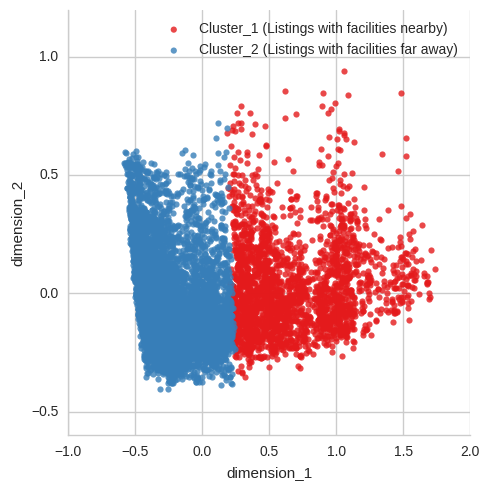

In [13]:
ax = sns.lmplot(x='dimension_1', y='dimension_2', data=X, fit_reg=False, hue='label', legend=False, palette='Set1')
plt.legend(['Cluster_1 (Listings with facilities nearby)','Cluster_2 (Listings with facilities far away)'])

In [14]:
df = pd.read_csv('df_for_model_building.csv')

# Keep only the price column and variables that correspond to distance to neighbourhood amenities 
df = df.ix[:,['price', 'restaurant', 'atm', 'cinema', 'hospital', 'nightclub', 'park','mall', 
              'gallery', 'museum', 'supermarket', 'bus_stop']]

df['label'] = cluster_model.labels_
np.round(df.groupby(by='label').mean())

,price,restaurant,atm,cinema,hospital,nightclub,park,mall,gallery,museum,supermarket,bus_stop
label,,,,,,,,,,,,
0,80.0,533.0,1593.0,2630.0,3882.0,8253.0,1785.0,7024.0,11459.0,6111.0,756.0,194.0
1,110.0,202.0,760.0,1339.0,1607.0,1544.0,1747.0,2204.0,2411.0,1277.0,323.0,186.0


<code>The 2 clusters represent the expensive v/s the cheaper houses. As evident from the mean values above, cluster_1 are the expensive houses since they also have the facilities nearby (the distance to atm, cinema, nightclub are much lower). Cluster_2 refers to listing probably not in the downtown area or so, and hence tend to have lower prices (but farther away from amenities).</code>